In [103]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [104]:
import numpy as np
import pandas as pd

In [105]:
import datetime as dt
from datetime import datetime
from datetime import date, timedelta

In [106]:
from matplotlib import dates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator
from sqlalchemy import inspect
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [107]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [108]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [109]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [110]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [111]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [112]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [113]:
# measurement
first_measurement = session.query(Measurement).first()
first_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x12d32866cd0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [114]:
# station
first_station = session.query(Station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x12d550ed310>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

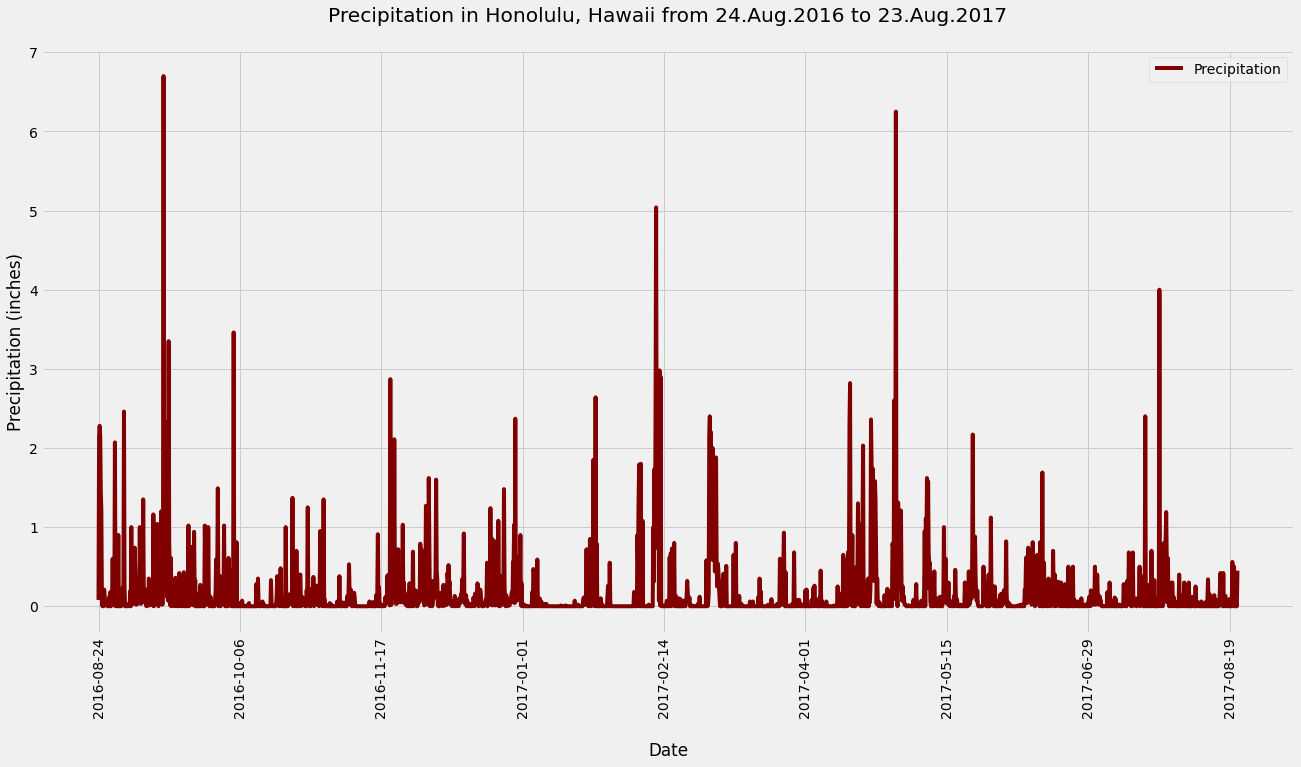

In [115]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_day = datetime.strptime(latest_day, '%Y-%m-%d')
# latest_day

# Calculate the date 1 year ago from the last data point in the database
strptime_dt = latest_day -timedelta(days=365)
# strptime_dt

# Perform a query to retrieve the data and precipitation scores
one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=strptime_dt).all()
# one_year

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(one_year, columns = ['Date', 'Precipitation'])
prcp_df=prcp_df.set_index('Date')

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)
prcp_df=prcp_df.dropna()
# prcp_df

# Use Pandas Plotting with Matplotlib to plot the data

fig, ax= plt.subplots(figsize = (20, 10))
prcp_df.plot(ax = ax, color='maroon')
ax.set_title('Precipitation in Honolulu, Hawaii from 24.Aug.2016 to 23.Aug.2017\n')
ax.set_ylabel('Precipitation (inches)')
ax.set_xlabel('\nDate')
plt.xticks(rotation=90)
plt.savefig('Images/Precipitation_Graph.png',bbox_inches = 'tight')
plt.tight_layout
plt.show()

In [116]:
# Use Pandas to calcualte the summary statistics for the precipitation data

#Formatting
pd.options.display.float_format = '{:,.2f}'.format

prcp_df.describe()

,Precipitation
count,"2,015.00"
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [117]:
# Design a query to show how many stations are available in this dataset?
sta_count = session.query(func.count(Station.station)).all()
sta_count


[(9)]

In [118]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [119]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stats = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

# Temperature stats from station USC00519281
min,max,avg = session.query(*temp_stats).filter(Measurement.station=='USC00519281').first()
print(f'''Min Temperature was {min} F
Max Temperature was {max} F
Average Temperature was {avg:.2f} F''')


Min Temperature was 54.0 F
Max Temperature was 85.0 F
Average Temperature was 71.66 F


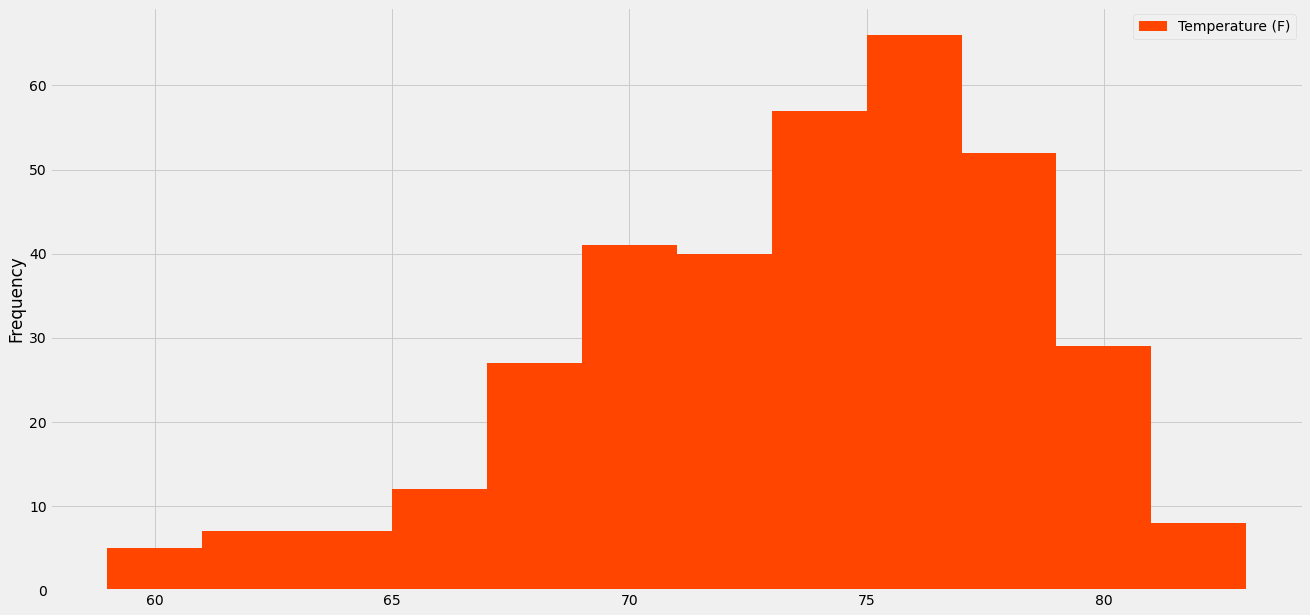

In [120]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date>=strptime_dt).all()
temp_obs

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(temp_obs, columns = ['Temperature (F)'])
temp_df

# temp_df=temp_df.dropna()
# temp_df

# Histogram
temp_df.plot.hist(by=None, bins=12, figsize=(20,10), color='orangered')
ax.set_title('Temperature in Honolulu, Hawaii from 24.Aug.2016 to 23.Aug.2017\n')
ax.set_ylabel('Temperature (F)')
plt.savefig('Images/Temperature_Histogram.png',bbox_inches = 'tight')
plt.tight_layout
plt.show()

## Bonus Challenge Assignment

In [121]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [122]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2017-08-06', '2017-08-14'))


[(71.0, 79.32432432432432, 84.0)]


In [123]:
trip_df = pd.DataFrame(calc_temps('2017-08-06', '2017-08-14'), columns = ['Min Temperature (F)','Average Temperature (F)','Max Temperature (F)'])
trip_df

,Min Temperature (F),Average Temperature (F),Max Temperature (F)
0,71.00,79.32,84.00


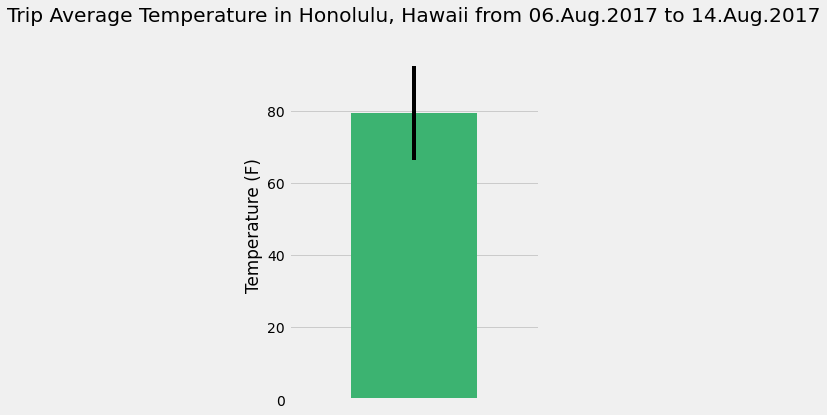

In [124]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Bar chart
trip_df.plot.bar(y="Average Temperature (F)", yerr=(trip_df['Max Temperature (F)'] - trip_df['Min Temperature (F)']) , figsize=(4,6), color='mediumseagreen')
plt.title('Trip Average Temperature in Honolulu, Hawaii from 06.Aug.2017 to 14.Aug.2017\n')
plt.ylabel('Temperature (F)')
plt.gca().legend_.remove()
plt.xticks([])
plt.xticks(np.arange(1,1.0))
plt.savefig('Images/Trip_Avg_Temp.png',bbox_inches = 'tight')
plt.tight_layout
plt.show()

In [125]:
# Temperature Analysis I

# Identify the average temperature in June at all stations across all available years in the dataset
june_avg_temp = session.query(func.avg(Measurement.tobs)).filter(func.strftime('%m', Measurement.date) == '06').all()
june_avg_temp = list(np.ravel(june_avg_temp))[0]
june_avg_temp

# Identify the average temperature in December at all stations across all available years in the dataset
dec_avg_temp = session.query(func.avg(Measurement.tobs)).filter(func.strftime('%m', Measurement.date) == '12').all()
dec_avg_temp = list(np.ravel(dec_avg_temp))[0]
dec_avg_temp

#Print results
print (f'The average temperature in June at all stations across all available years in the dataset is {round(june_avg_temp,2)} (F)')
print (f'The average temperature in December at all stations across all available years in the dataset is {round(dec_avg_temp,2)} (F)')


The average temperature in June at all stations across all available years in the dataset is 74.94 (F)
The average temperature in December at all stations across all available years in the dataset is 71.04 (F)


In [126]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant

# June
jun_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06').all()
# December
dec_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12').all()

# T Test
stats.ttest_ind(jun_temps, dec_temps, equal_var=False)

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

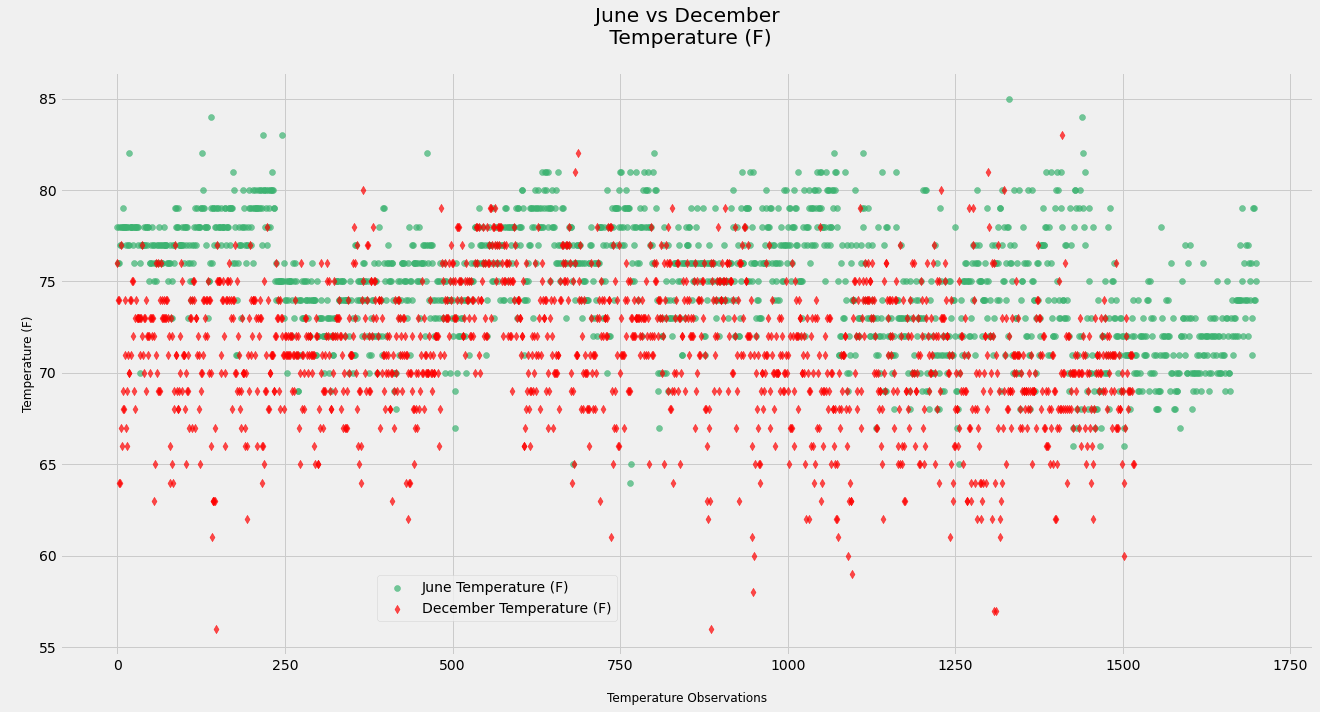

In [127]:
# Scatter plot of June and December data
# plt.subplot(1,1,1)
fig, ax= plt.subplots(figsize = (20,10))
plt.scatter(range(len(jun_temps)), jun_temps, label = 'June Temperature (F)', marker='o', color='mediumseagreen', alpha=0.7)
plt.scatter(range(len(dec_temps)), dec_temps, label = 'December Temperature (F)', marker='d', color='red', alpha=0.7)
plt.legend(bbox_to_anchor=(0.45, 0.15))
plt.title(f'June vs December\n Temperature (F)\n')
plt.xlabel('\nTemperature Observations', fontsize = 12)
plt.ylabel('\nTemperature (F)', fontsize = 12)
plt.savefig('Images/Jun_Dec_Temp.png',bbox_inches = 'tight')
plt.show()

In [128]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-06'
end_date = '2017-08-14'
selection = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]
weather_station = session.query(*selection).filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

weather_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  None),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.0)]

In [129]:
# Create a Data Frame for visualization
weather_station_df = pd.DataFrame(weather_station, columns = ['Station','Station Name','Latitude','Longitude','Elevation','Total Rain Fall'])
weather_station_df

,Station,Station Name,Latitude,Longitude,Elevation,Total Rain Fall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33,-157.80,152.40,nan
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52,-157.84,7.00,0.00
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.34,-157.71,19.50,0.00
3,USC00519397,"WAIKIKI 717.2, HI US",21.27,-157.82,3.00,0.00
4,USC00519281,"WAIHEE 837.5, HI US",21.45,-157.85,32.90,0.00


In [137]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [132]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# dn = [daily_normals("08-06"),daily_normals("08-07"),daily_normals("08-08"),daily_normals("08-09"),daily_normals("08-10"),daily_normals("08-11"),daily_normals("08-12"),\
#         daily_normals("08-13"),daily_normals("08-14")]
# dn

# Set the start and end date of the trip

start_date = (dt.datetime.strptime('2017-08-06', "%Y-%m-%d")).date()
end_date = (dt.datetime.strptime('2017-08-14', "%Y-%m-%d")).date()

print(start_date)
print(end_date)


2017-08-06
2017-08-14


In [135]:
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

range_dates = []

current_date = start_date
while current_date <= end_date:
    month = current_date.strftime('%m')
    day = current_date.strftime('%d')
    range_dates.append(f"{month}-{day}")
    current_date += dt.timedelta(days=1)

range_dates

['08-06',
 '08-07',
 '08-08',
 '08-09',
 '08-10',
 '08-11',
 '08-12',
 '08-13',
 '08-14']

In [140]:
# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
for i in range(len(range_dates)):
    dn = daily_normals(range_dates[i])
    normals.append(dn[0])

normals


[(67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0)]

In [142]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

daily_normals_df = pd.DataFrame(normals, columns =['Min Temperature (F)', 'Avg Temperature (F)', 'Max Temperature (F)'])
daily_normals_df["Date"] = range_dates
daily_normals_df.set_index("Date")


,Min Temperature (F),Avg Temperature (F),Max Temperature (F)
Date,,,
08-06,67.00,76.25,83.00
08-07,71.00,77.16,83.00
08-08,68.00,76.56,83.00
08-09,69.00,75.98,81.00
08-10,65.00,76.42,83.00
08-11,67.00,75.98,82.00
08-12,67.00,76.53,83.00
08-13,71.00,76.98,84.00
08-14,71.00,76.78,82.00


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

